# tSZ analysis using CMB frequency maps
A fit on a set of simulated CMB frequency maps using Cobaya.

## Simulation 
The frequency maps are simulated using galaxy cluster spatial profile templates.
In this example tSZ spatial profiles created by Emanuale D'Angelo is used (tsz_template.fits and vmaps.fits). 
Only first four frequency channels are used.
Also, please note that the cluster templates are convolved with a beam.

$Obs_{tSZ}(\nu) = f(y_{cl},\nu)T(\nu) + N\sqrt{V(\nu)}$

$T(\nu)$ - template for the galaxy cluster spatial profile.
$N$ - random normal matrix.
$V(\nu)$ - Variance map.

$f(y_{cl}, \nu)$ is the amplitude of the tSZ signal in the corresponding frequency band. Which is given the tSZ spectrum functions code by Gemma Luzzi.


The $χ^{2}$ and the likelihood is defined as

$χ^{2} =  \sum\limits_{\nu} \sum\limits_{i,j} \frac{[f(y_{cl},\nu)T_{\nu}(i,j) - Obs_{\nu}(i,j)]^{2}}{V_{\nu}(i,j)}$

$P(Obs_{tSZ}|y_{cl}) \propto  exp(-χ^{2})$

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import functionsz as f_sz
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from cobaya.run import run

In [2]:
def plots_line(images, figtitle = None, labels = [], output = None):

    num_images = len(images)
    fig, axs = plt.subplots(1, num_images, figsize=(num_images*3,3))
    for i in range(num_images):
        ax=axs[i]
        if len(labels) != 0:
            ax.set_title(labels[i])
        image=ax.imshow(images[i])
        divider = make_axes_locatable(ax)
        cbar=plt.colorbar(image, orientation='horizontal', shrink=0.7, ticks = [np.min(images[i]), np.max(images[i])])

    fig.suptitle(figtitle, fontsize=16)

    fig.tight_layout()
    if output == None:
        plt.show()
    else:
        plt.savefig(output, dpi=300)

In [63]:
# Input data: Frequency maps and corresponding variance maps

#set input and output folders
input_folder = "/home/vipul/sz_analysis/MappeMock/"
cobaya_output_folder = "/home/vipul/Y-maps/cobaya_output/"

cluster_name = "psz2g346.61+35.06" #"psz2g263.68-22.55" 
cluster_tsz_template = fits.open(input_folder + "{}/PR2/{}_noysz217_tsz_template.fits".format(cluster_name, cluster_name))[0].data
#varmaps unit microkelvin. 
cluster_var_maps = fits.open(input_folder + "{}/PR2/{}_noysz217_vmaps.fits".format(cluster_name, cluster_name))[0].data*1e3
grid_size = np.shape(cluster_tsz_template[0])[0] 
cluster_stddev = np.sqrt(cluster_var_maps)

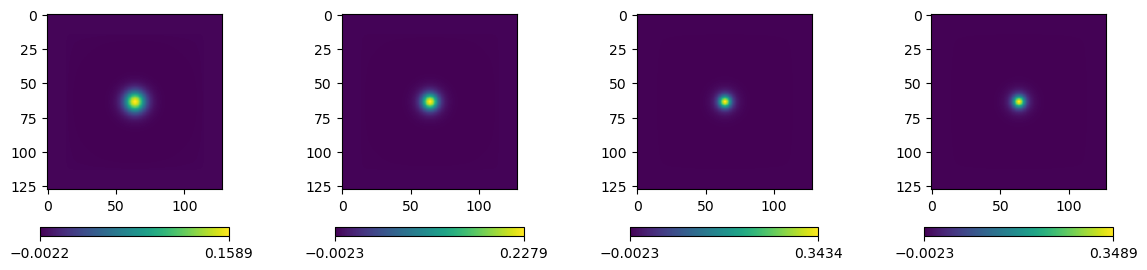

In [41]:
plots_line(cluster_tsz_template[0:4])

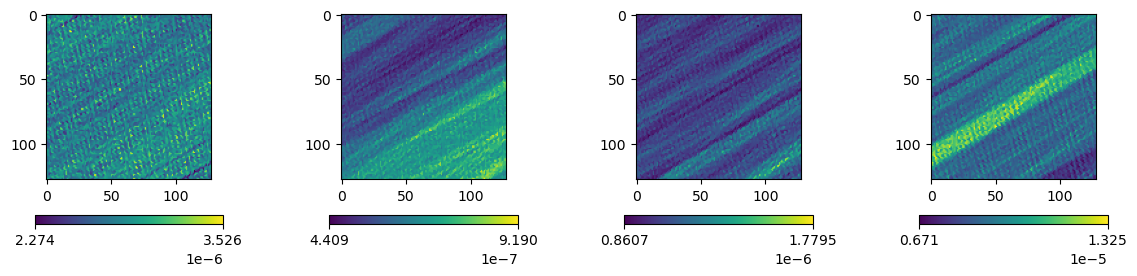

In [42]:
plots_line(cluster_var_maps[0:4])

[-0.4065394  -0.28288995  0.0201081   0.65056721]


Text(0.5, 1.0, 'tSZ signal amplitude')

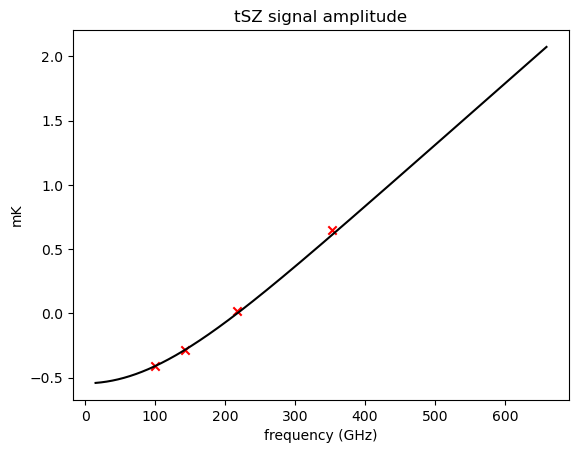

In [62]:
# Amplitude of the tSZ signal

#Physical constants for calculating the spectral amplitude
t0=2.725
me=510.99890
c=2.99792e10
c_km=c*1e-5
kb=1.380650e-23
h=6.62607e-34
cn=c*1e-9
hc=h*c
co=1.

const = {'t0':t0,'me':me,'c':c, 'c_km':c*1e-5,'cn':c*1e-9,'kb':kb,'h':h,'hc':hc,'co':co}

# Frequency initialization
n_min=0.5
n_max=22
step_ni=0.01
n_ni=round((n_max-n_min)/step_ni)
ni=n_min*np.ones(n_ni)+step_ni*np.array(range(n_ni))
nu_GHz=ni*cn
pxsize=128
centerfreq = np.array([100.000, 143.000, 217.000, 353.0005]) # the four frequency bands used
n_freq=len(centerfreq)
Rmask=5

Ycl_input = 1e-4 # input value for cluster y parameter
T_kev = 0
V_pec = 0
Z = 0.1
Tcmb = t0*(1+Z)

# tSZ spectral shape is given by 
f_nu = f_sz.rel_corr_batch_bis(Ycl_input, T_kev, V_pec, Tcmb,nu_GHz*(1.+Z), const, f_sz.rel_corr_batch_init(Tcmb,nu_GHz*(1.+Z), const), 6) 

# The band integrated value of the tSZ spectral amplitude for frequency bands is given by following
f_nu_band_intgrated = f_sz.sz_forecast(Ycl_input, T_kev, V_pec, Tcmb, Z, centerfreq, f_sz.rel_corr_batch_init(Tcmb,nu_GHz*(1.+Z), const), nu_GHz, const, 6)


print(f_nu_band_intgrated)

plt.plot(nu_GHz, f_nu, 'k')
plt.scatter(centerfreq, f_nu_band_intgrated, marker = 'x', color = 'red')
plt.xlabel(r"frequency (GHz)")
plt.ylabel(r"mK")
plt.title("tSZ signal amplitude")


---100.0 GHz---
max template =  0.15890776
f nu =  -0.4065393991938219
Max of f(nu)*template =  0.0
Max of sqrt(cluster_vmaps) =  0.0018777783
SNR =  0.0

---143.0 GHz---
max template =  0.22786653
f nu =  -0.2828899475114373
Max of f(nu)*template =  0.0
Max of sqrt(cluster_vmaps) =  0.0009586233
SNR =  0.0

---217.0 GHz---
max template =  0.3433765
f nu =  0.020108097687773042
Max of f(nu)*template =  0.0
Max of sqrt(cluster_vmaps) =  0.0013339727
SNR =  0.0

---353.0005 GHz---
max template =  0.34885168
f nu =  0.650567207358721
Max of f(nu)*template =  0.0
Max of sqrt(cluster_vmaps) =  0.0036400121
SNR =  0.0


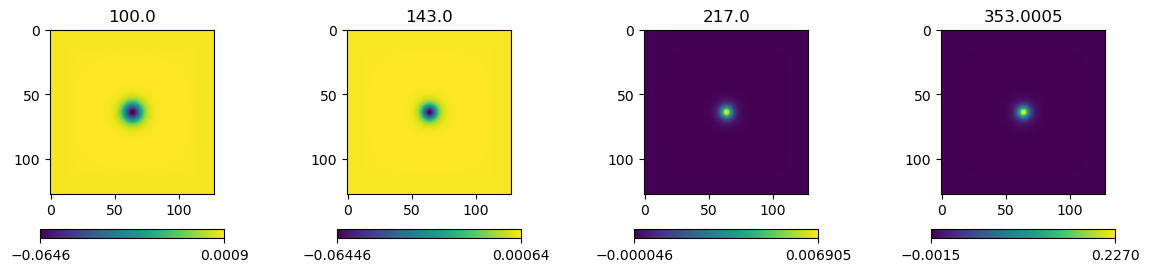

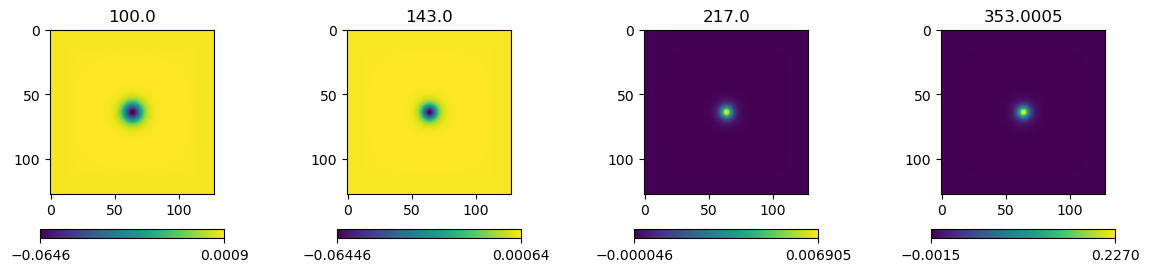

In [44]:
# Creating the simulated frequency maps

Map_obs_nu = np.zeros((n_freq,grid_size, grid_size))
noise_nu = np.zeros((n_freq,grid_size, grid_size))
Ycl_map_nu = np.zeros((n_freq,grid_size, grid_size))

for i in range(n_freq):
  print("\n---{} GHz---".format(centerfreq[i]))
  noise = np.multiply(cluster_stddev[i], np.random.normal(0, 1, size = (grid_size,grid_size)))
  Ycl_map = f_nu_band_intgrated[i]*cluster_tsz_template[i]
  print("max template = ", np.max(cluster_tsz_template[i]))
  print("f nu = ", f_nu_band_intgrated[i])
  print("Max of f(nu)*template = ", np.max(np.abs(Ycl_map[i])))
  print("Max of sqrt(cluster_vmaps) = ", np.max(np.abs(cluster_stddev[i])))
  print("SNR = ", np.max(np.abs(Ycl_map[i]))/np.max(np.abs(cluster_stddev[i])))
  # Map_obs = ndimage.gaussian_filter(np.add(Ysz_map, noise), sigma=5, order=0, axes=0)
  Map_obs = np.add(Ycl_map, noise)

  Ycl_map_nu[i,:,:] = Ycl_map
  noise_nu[i,:,:] = noise
  Map_obs_nu[i,:,:] = Map_obs

plots_line(Ycl_map_nu, labels = centerfreq)
plots_line(Ycl_map_nu, labels = centerfreq)

In [65]:
# fit using Cobaya

def likelihood_Ysz(Ycl):
  # likelikhood = exp(- chi_squure)
  f_nu_band_intgrated_val = f_sz.sz_forecast(Ycl, T_kev, V_pec, Tcmb, Z, centerfreq, f_sz.rel_corr_batch_init(Tcmb,nu_GHz*(1.+Z), const), nu_GHz, const, 6)
  Map_predict_nu = np.zeros((n_freq,grid_size, grid_size))
  for i in range(n_freq):
    Map_predict_nu[i,:,:] = f_nu_band_intgrated_val[i]*cluster_tsz_template[i,:,:]
  chisqr = np.sum((Map_obs_nu - Map_predict_nu)**2/cluster_var_maps[0:4])
  return -chisqr

info={
      "likelihood": {"chisqr": likelihood_Ysz},
      "params": {"Ycl": {"prior":{"min":1e-6, "max":1e-3}, "ref":{"dist": 'norm', "loc":Ycl_input, "scale":Ycl_input}, "proposal":Ycl_input/30}},
      "sampler": {"mcmc": {"Rminus1_stop": 0.008, "max_tries": 100000, "learn_proposal":True}},
      "force": True
      }

if not os.path.exists(cobaya_output_folder+cluster_name):
      os.mkdir(cobaya_output_folder+cluster_name)

info["output"] = cobaya_output_folder +"{}_freqmaps_analysis_cobaya".format(cluster_name)
print(info)

updated_info_Ycl, sampler_Ycl = run(info)
updated_info_minimizer_Ycl, minimizer_Ycl = run(info, minimize=True)

{'likelihood': {'chisqr': <function likelihood_Ysz at 0x7d797393f490>}, 'params': {'Ycl': {'prior': {'min': 1e-06, 'max': 0.001}, 'ref': {'dist': 'norm', 'loc': 0.0001, 'scale': 0.0001}, 'proposal': 3.3333333333333333e-06}}, 'sampler': {'mcmc': {'Rminus1_stop': 0.008, 'max_tries': 100000, 'learn_proposal': True}}, 'force': True, 'output': '/home/vipul/Y-maps/cobaya_output/psz2g346.61+35.06_freqmaps_analysis_cobaya'}
[output] Output to be read-from/written-into folder '/home/vipul/Y-maps/cobaya_output', with prefix 'psz2g346.61+35.06_freqmaps_analysis_cobaya'
[output] Found existing info files with the requested output prefix: '/home/vipul/Y-maps/cobaya_output/psz2g346.61+35.06_freqmaps_analysis_cobaya'
[output] Will delete previous products ('force' was requested).
[chisqr] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: Ycl:0.000154356
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured

   weight  minuslogpost     Ycl  minuslogprior  minuslogprior__0  \
0     1.0   65699.25294  0.0001      -6.908756         -6.908756   

            chi2   chi2__chisqr  
0  131412.323391  131412.323391  
[root] *WARNING* outlier fraction 0.10185185185185185 
Mean: 9.997370584625883e-05
Covariance matrix, stddev: [[7.03573328e-15]] 8.387927802223286e-08
[root] *WARNING* auto bandwidth for chi2 very small or failed (h=0.0005735176126219812,N_eff=474.17456961643006). Using fallback (h=0.004182942374547745)


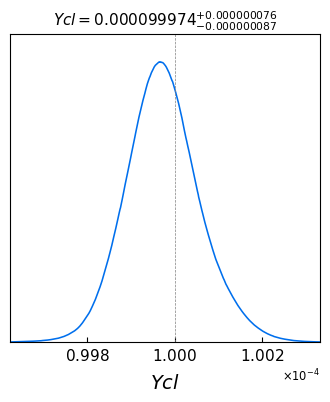

In [66]:
print(minimizer_Ycl.products()["minimum"])
peak_ycl = minimizer_Ycl.products()["minimum"]["Ycl"]
ycl_limits = {'Ysz': (Ycl_input - 1.5e-4, Ycl_input + 1.5e-4)} #x-axis limits to make the plot symmetric wrt peak.

# Export the results to GetDist
gd_sample = sampler_Ycl.products(skip_samples=0.3, to_getdist=True)["sample"]

# Analyze and plot
Ysz_fit = gd_sample.getMeans(pars = [0])[0]
Ysz_fit_covariance = gd_sample.getCovMat().matrix
Ysz_fit_stddev = np.sqrt(Ysz_fit_covariance[0][0])
print("Mean:", Ysz_fit)
print("Covariance matrix, stddev:", Ysz_fit_covariance, Ysz_fit_stddev)
# uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

gdplot = gdplt.get_subplot_plotter(subplot_size = 4)
gdplot.triangle_plot(gd_sample, ["Ycl"], filled=True, markers={"Ycl":Ycl_input},title_limit = 1)